In [1]:

# Install and import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [2]:

# Download Google stock data for last 20 years
end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)
stock = "GOOG"
google_data = yf.download(stock, start, end)


C:\Users\anand\AppData\Local\Temp\ipykernel_90832\254695863.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  google_data = yf.download(stock, start, end)
[*********************100%***********************]  1 of 1 completed


In [3]:

# Plot function
def plot_graph(figsize, values, column_name):
    plt.figure(figsize=figsize)
    if isinstance(values, pd.DataFrame):
        for col in values.columns:
            plt.plot(values.index, values[col], label=col)
    else:
        plt.plot(values.index, values, label=column_name)
    plt.legend()
    plt.xlabel("Years")
    plt.ylabel(column_name)
    plt.title(f"{column_name} of Google Stock Data")
    plt.show()


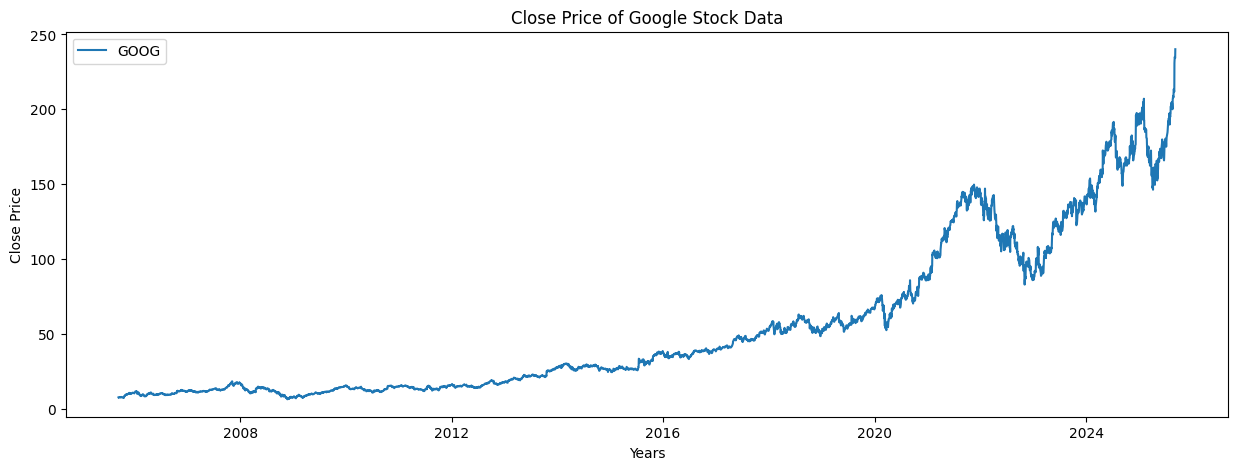

In [4]:

# Plot Closing Price
plot_graph((15, 5), google_data['Close'], 'Close Price')


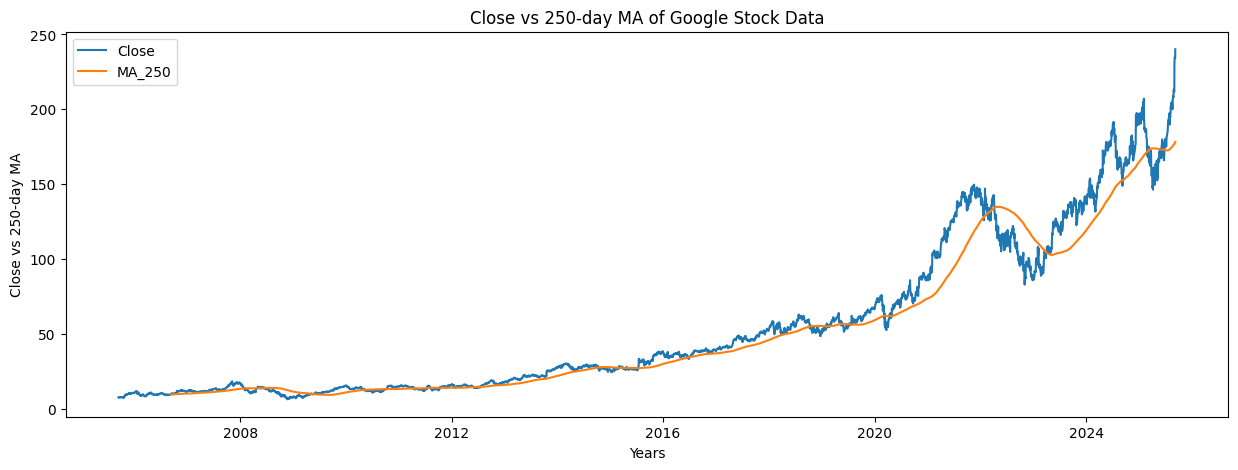

In [6]:

# Moving Average Example
google_data[('MA_250', '')] = google_data[('Close', 'GOOG')].rolling(window=250).mean()
plot_graph((15, 5), pd.DataFrame({
    'Close': google_data[('Close', 'GOOG')],
    'MA_250': google_data[('MA_250', '')]
}), 'Close vs 250-day MA')


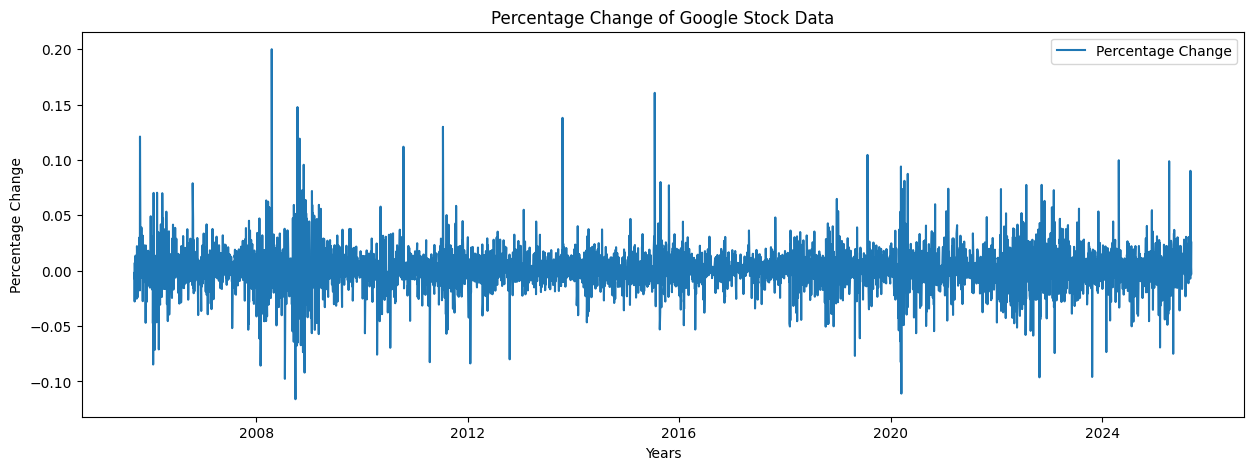

In [10]:
# Percentage Change Example

google_data['Pct_Change'] = google_data[('Close', 'GOOG')].pct_change()
plot_graph((15,5), google_data['Pct_Change'], 'Percentage Change')


In [12]:

# Prepare Data for LSTM
close_price = google_data[[('Close', 'GOOG')]]
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_price)

# Create sequences for LSTM
x_data, y_data = [], []
for i in range(100, len(scaled_data)):
    x_data.append(scaled_data[i-100:i])
    y_data.append(scaled_data[i])

x_data, y_data = np.array(x_data), np.array(y_data)

# Split into training and testing sets
split_len = int(len(x_data) * 0.7)
x_train = x_data[:split_len]
y_train = y_data[:split_len]
x_test = x_data[split_len:]
y_test = y_data[split_len:]


In [13]:

# Define LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(x_train, y_train, batch_size=1, epochs=2)


Epoch 1/2


c:\Users\anand\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3451/3451 ━━━━━━━━━━━━━━━━━━━━ 65s 18ms/step - loss: 1.0548e-04
Epoch 2/2
3451/3451 ━━━━━━━━━━━━━━━━━━━━ 77s 22ms/step - loss: 4.1705e-05


In [14]:

# Predictions
predictions = model.predict(x_test)
inv_predictions = scaler.inverse_transform(predictions)
inv_y_test = scaler.inverse_transform(y_test)

# Calculate RMSE
rmse = np.sqrt(np.mean((inv_predictions - inv_y_test)**2))
print(f"RMSE: {rmse}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
RMSE: 3.8671339755296454


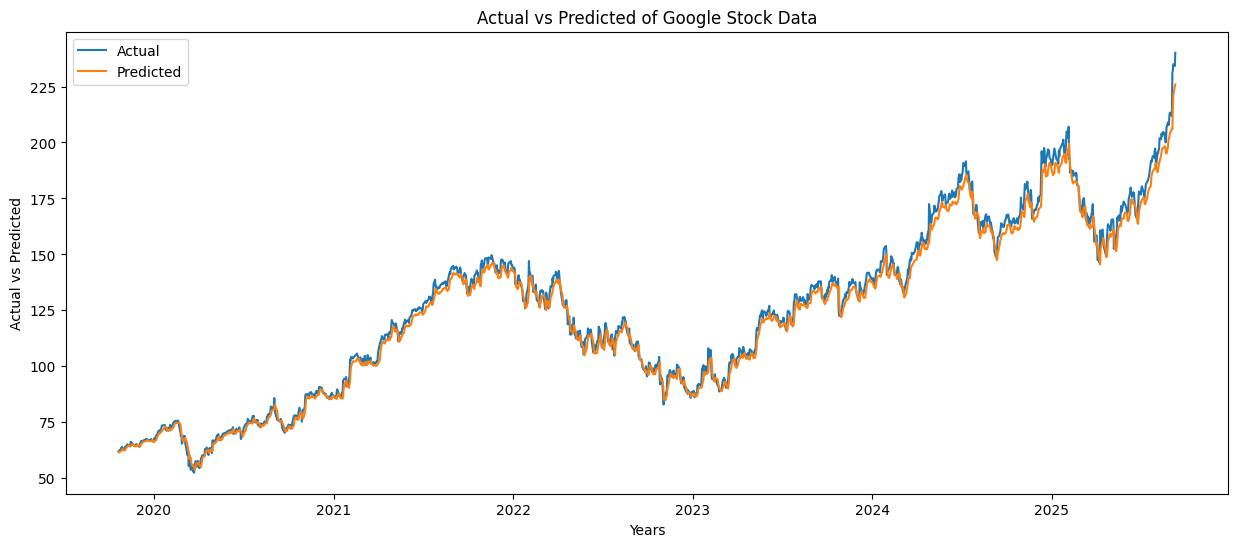

In [15]:

# Plot actual vs predicted
plot_data = pd.DataFrame({
    'Actual': inv_y_test.reshape(-1),
    'Predicted': inv_predictions.reshape(-1)
}, index=google_data.index[split_len + 100:])

plot_graph((15,6), plot_data, 'Actual vs Predicted')


In [16]:

# Save the trained model
model.save("Latest_stock_price_model.keras")
